In [ ]:
# 29/10/20
# ok got a working version!!!

In [ ]:
# from my experiments it seems like ExU units can't
# take 2D inputs so need to do the NAMs for multi-input
# but the residual based method seems to work for 2D at least!

In [ ]:
# based on
# https://gitlab.com/SpaceTimeKhantinuum/scrinet/-/blob/master/examples/fits/nnfit-2d.ipynb

In [1]:
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

def relu_n(x, n = 1):
    """ReLU activation clipped at n."""
    return tf.clip_by_value(x, 0, n)


class ExU(Layer):
    def __init__(self, units):
        super(ExU, self).__init__()
        self.units = units
        self._w_initializer = tf.initializers.TruncatedNormal(
          mean=4.0, stddev=0.5)
        
    def build(self, input_shape):
        # input_shape[-1] is the number of features
        self.w = self.add_weight(
            name="w",
            shape=(input_shape[-1], self.units),
            initializer=self._w_initializer,
            trainable=True
        )
        self.b = self.add_weight(
            name="b",
            shape=(1, self.units),
            # NOTE HERE I INCREASED THE STDDEV! FROM 0.5 to 1.5. THIS REALLY HELPED FIT THE EDGES!
            initializer=tf.initializers.TruncatedNormal(stddev=1.5),
            trainable=True
        )
        
    def call(self, inputs):
        
#         this tile is row_stack tf.shape(x)[0] times
        centre = tf.tile(self.b, [tf.shape(inputs)[0], 1])
        return relu_n(tf.math.exp(self.w) * (inputs - centre))
#         return tf.matmul(inputs, self.w) + self.b



class ExUnd(Layer):
    def __init__(self, units):
        super(ExUnd, self).__init__()
        self.units = units
        self._w_initializer = tf.initializers.TruncatedNormal(
          mean=4.0, stddev=0.5)
        
    def build(self, input_shape):
        # input_shape[-1] is the number of features
        self.w = self.add_weight(
            name="w",
            shape=(input_shape[-1], self.units),
            initializer=self._w_initializer,
            trainable=True
        )
        
        self.b = self.add_weight(
            name="b",
            shape=(1, self.units),
            # NOTE HERE I INCREASED THE STDDEV! FROM 0.5 to 1.5. THIS REALLY HELPED FIT THE EDGES!
            initializer=tf.initializers.TruncatedNormal(stddev=1.5),
            trainable=True
        )
#         print("b ", self.b)
        
    def call(self, inputs):
#         inputs = inputs.numpy()
        
#         this tile is row_stack tf.shape(x)[0] times
#         centre = tf.tile(self.b, [tf.shape(inputs)[0], 1])
#         b = self.b.numpy()
        
#         print("\n")
#         print(f"inputs.shape: {inputs.shape}\n")
#         print(f"b: {b.shape}\n")
#         print(f"self.w: {self.w.shape}\n")
        
#         print("inputs-centre")
#         xmc = inputs-centre

#         w = self.w.numpy()
        
        # j loops over the number of units
        
        # i loops over the number of features
        
        out = np.zeros(shape=(self.units), dtype=np.float32)
    
#         print("\n")
#         print(f"input: {inputs}\n")
#         print(f"b: {b}\n")
#         print(f"w: {w}\n")
        
        for j in tf.range(self.units):
#             print(f"j = {j}")
            summed = 0.
            for i in tf.range(inputs.shape[1]):
#                 print(f"i = {i}")
                summed += (inputs[0, i] - self.b[0, j])
#                 print("summed", summed)
            out[j] = summed * tf.math.exp(self.w[i, j])
        

#         print("pre-relu_n", out)
#         print("return")

        return relu_n(out)
#         return relu_n(tf.math.exp(self.w) * (inputs - centre))
#         return tf.matmul(inputs, self.w) + self.b

In [191]:
class ExU_ND(Layer):
    def __init__(self, units):
        super(ExU_ND, self).__init__()
        self.units = units
        self._w_initializer = tf.initializers.TruncatedNormal(
          mean=4.0, stddev=0.5)
        
    def build(self, input_shape):
        # input_shape[-1] is the number of features
        self.w = self.add_weight(
            name="w",
            shape=(input_shape[-1], self.units),
            initializer=self._w_initializer,
            trainable=True
        )
        self.b = self.add_weight(
            name="b",
            shape=(1, self.units),
            # NOTE HERE I INCREASED THE STDDEV! FROM 0.5 to 1.5. THIS REALLY HELPED FIT THE EDGES!
            initializer=tf.initializers.TruncatedNormal(stddev=0.5),
            trainable=True
        )
        
    def call(self, inputs):
        
        c_pij = tf.transpose(inputs, perm=[0,1])[...,tf.newaxis] - self.b
        h = tf.reduce_sum(c_pij * tf.math.exp(self.w), axis=1)

        return relu_n(h)
#         return tf.matmul(inputs, self.w) + self.b

In [4]:
exu_layer_old = ExUnd(3)
# exu_layer_old(tf.ones(shape=(4, 2)))
exu_layer_old(tf.ones(shape=(1, 5)))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 1., 1.], dtype=float32)>

In [5]:
exu_layer = ExU_ND(3)
# exu_layer(tf.ones(shape=(4, 2)))
exu_layer(tf.ones(shape=(1, 5)))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0., 1., 1.]], dtype=float32)>

In [6]:
exu_layer.get_weights()

[array([[4.2722325, 4.614639 , 3.30817  ],
        [4.010287 , 4.056979 , 3.9751287],
        [3.8629525, 3.8495033, 4.421955 ],
        [4.4583793, 4.0508585, 3.6487982],
        [3.9649448, 3.554019 , 3.9995756]], dtype=float32),
 array([[ 1.5755414 , -0.07232249, -0.5327165 ]], dtype=float32)]

In [7]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rcParams.update({'font.size': 16}) 

import numpy as np

In [99]:
import pugna.data

def preproc(data, method="MinMaxScaler", feature_range=(-1,1)):
    scalers = pugna.data.make_scalers(data, method=method, feature_range=feature_range)
    data_scaled = pugna.data.apply_scaler(data, scalers)
    return data_scaled, scalers

In [192]:
def gen_data(X):
    y = X[:,0] * np.sin(X[:,0]*10) + 1 + .4 * np.sin(X[:,1])
    y += np.random.uniform(0, 0.1, size=(len(y)))
    return y

In [255]:
# generate some fake data
x = np.linspace(0,1,20)
xx, yy = np.meshgrid(x,x)
xx = xx.ravel()
yy = yy.ravel()
X = np.zeros(shape=(len(xx), 2))
X[:,0] = xx
X[:,1] = yy

y = gen_data(X)

In [259]:
# validation data
# generate some fake data
x = np.random.uniform(0,1,size=20)
xx, yy = np.meshgrid(x,x)
xx = xx.ravel()
yy = yy.ravel()
X_val = np.zeros(shape=(len(xx), 2))
X_val[:,0] = xx
X_val[:,1] = yy

y_val = gen_data(X_val)

Text(0.5, 1.0, 'training set')

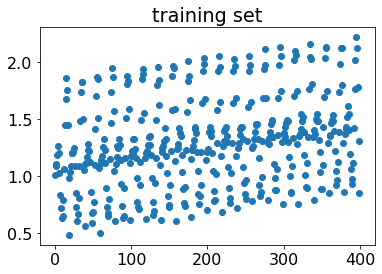

In [260]:
plt.figure()
plt.scatter(range(len(y)), y)
plt.title("training set")

Text(0.5, 1.0, 'validation set')

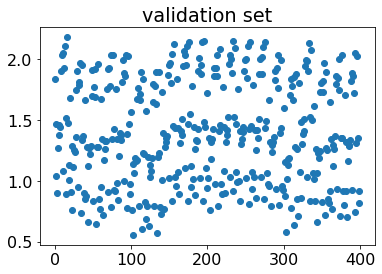

In [261]:
plt.figure()
plt.scatter(range(len(y_val)), y_val)
plt.title("validation set")

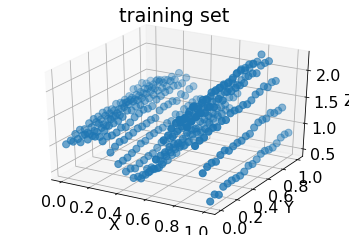

In [262]:
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.scatter(X[:,0], X[:,1], y, s=50)
plt.xlabel("X")
plt.ylabel("Y")
ax.set_zlabel("Z")
plt.title("training set")
plt.show()

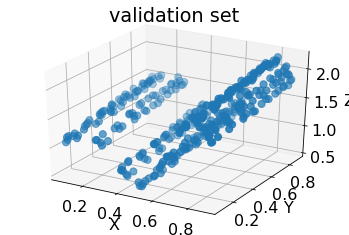

In [263]:
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.scatter(X_val[:,0], X_val[:,1], y_val, s=50)
plt.xlabel("X")
plt.ylabel("Y")
ax.set_zlabel("Z")
plt.title("validation set")
plt.show()

In [264]:
X.shape

(400, 2)

In [265]:
y.shape

(400,)

In [352]:
def get_base_model(x, y, verbose=True, batch_size=None, epochs=500, validation_data=None, lr=0.01):
    if batch_size is None:
        batch_size = x.shape[0]
        
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(2,)),
#         tf.keras.layers.Dense(600, activation='tanh'),
#         tf.keras.layers.Dense(600, activation='tanh'),
#         tf.keras.layers.Dense(200, activation='relu'),
#         tf.keras.layers.Dense(200, activation='relu'),
#         tf.keras.layers.Dense(1),
#         ExU(1000),
#         ExUnd(100),
        ExU_ND(2000),
        tf.keras.layers.Dense(600, activation='tanh'),
        tf.keras.layers.Dense(600, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(lr, amsgrad=True)
    model.compile(loss='mse', optimizer=optimizer)
    
    history = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=validation_data)
    
    return history, model

In [353]:
def get_later_model(x, y, verbose=True, batch_size=None, epochs=500, validation_data=None, lr=0.01):
    if batch_size is None:
        batch_size = x.shape[0]
        
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(2,)),
#         tf.keras.layers.Dense(600, activation='tanh'),
#         tf.keras.layers.Dense(600, activation='tanh'),
#         tf.keras.layers.Dense(400, activation='relu'),
#         tf.keras.layers.Dense(400, activation='relu'),
#         tf.keras.layers.Dense(400, activation='relu'),
#         tf.keras.layers.Dense(400, activation='relu'),
#         tf.keras.layers.Dense(1),
#         ExU(1000),
        ExU_ND(2000),
        tf.keras.layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(lr, amsgrad=True)
    model.compile(loss='mse', optimizer=optimizer)
    
    history = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=validation_data)
    
    return history, model

In [354]:
%%time
history1, model1 = get_base_model(X, y, epochs=2000, batch_size=X.shape[0], lr=0.001)

Epoch 1/2000
1/1 [==============================] - 0s 1ms/step - loss: 1.9152
Epoch 2/2000
1/1 [==============================] - 0s 941us/step - loss: 197.8745
Epoch 3/2000
1/1 [==============================] - 0s 944us/step - loss: 28.1117
Epoch 4/2000
1/1 [==============================] - 0s 726us/step - loss: 4.5841
Epoch 5/2000
1/1 [==============================] - 0s 1ms/step - loss: 21.7042
Epoch 6/2000
1/1 [==============================] - 0s 1ms/step - loss: 14.4979
Epoch 7/2000
1/1 [==============================] - 0s 1ms/step - loss: 4.4813
Epoch 8/2000
1/1 [==============================] - 0s 888us/step - loss: 0.4106
Epoch 9/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7207
Epoch 10/2000
1/1 [==============================] - 0s 1ms/step - loss: 2.3511
Epoch 11/2000
1/1 [==============================] - 0s 1ms/step - loss: 3.2076
Epoch 12/2000
1/1 [==============================] - 0s 676us/step - loss: 2.8716
Epoch 13/2000
1/1 [===============

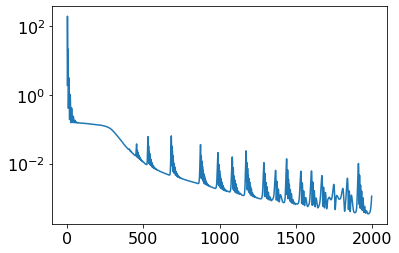

In [355]:
h1 = history1.history['loss']
plt.figure()
plt.plot(range(len(h1)), h1)
plt.yscale('log')

In [356]:
yhat = model1.predict(X)

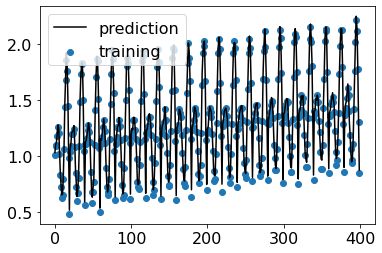

In [357]:
plt.figure()
plt.scatter(range(len(y)), y, label='training')
plt.plot(range(len(y)), yhat, label='prediction', c='k')
plt.legend()

In [358]:
yhat_val = model1.predict(X_val)

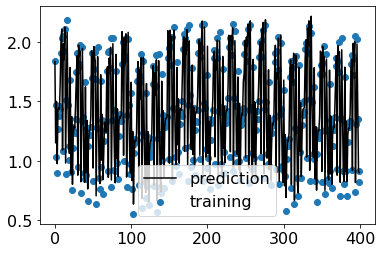

In [359]:
plt.figure()
plt.scatter(range(len(y_val)), y_val, label='training')
plt.plot(range(len(y_val)), yhat_val, label='prediction', c='k')
plt.legend()

Text(0.5, 1.0, 'training set difference')

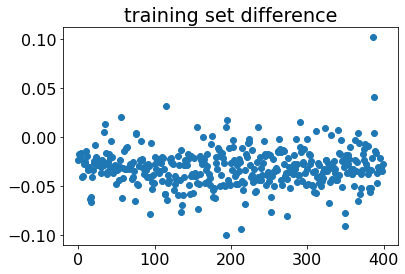

In [360]:
plt.figure()
plt.scatter(range(len(y)), y - yhat.reshape(-1))
plt.title("training set difference")

Text(0.5, 1.0, 'training set difference')

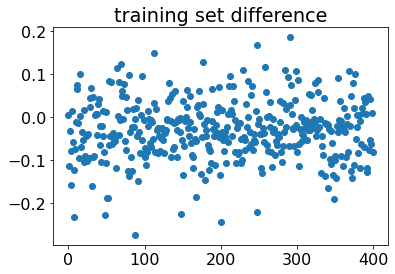

In [361]:
plt.figure()
plt.scatter(range(len(y_val)), y_val - yhat_val.reshape(-1))
plt.title("training set difference")

In [362]:
n_arr = np.arange(y.shape[0])
n_val_arr = np.arange(y_val.shape[0])

In [363]:
y.shape

(400,)

In [364]:
yhat.shape

(400, 1)

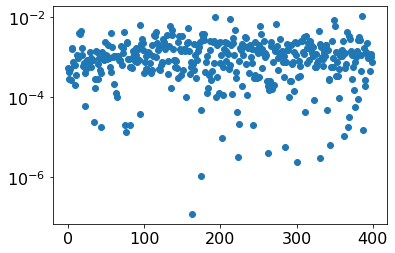

In [365]:
plt.figure()
plt.scatter(n_arr, tf.keras.losses.mean_squared_error(y[:,np.newaxis], yhat))
plt.yscale('log')

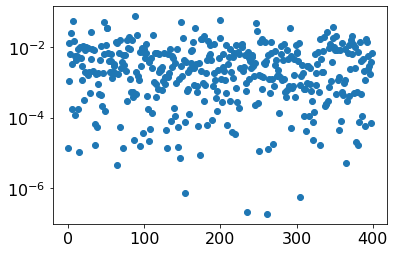

In [366]:
plt.figure()
plt.scatter(n_val_arr, tf.keras.losses.mean_squared_error(y_val[:,np.newaxis], yhat_val))
plt.yscale('log')

In [367]:
yRes = y - yhat[:,0]

In [368]:
y.shape

(400,)

In [369]:
yhat.shape

(400, 1)

In [370]:
yRes.shape

(400,)

In [371]:
yRes = yRes[:,np.newaxis]

In [372]:
yRes, scalers = preproc(yRes)

In [373]:
%%time
history2, model2 = get_later_model(X, yRes, epochs=2000, lr=0.001)

Epoch 1/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1472
Epoch 2/2000
1/1 [==============================] - 0s 959us/step - loss: 2.2295
Epoch 3/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1965
Epoch 4/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.6478
Epoch 5/2000
1/1 [==============================] - 0s 850us/step - loss: 1.3007
Epoch 6/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.7830
Epoch 7/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.1466
Epoch 8/2000
1/1 [==============================] - 0s 846us/step - loss: 0.1457
Epoch 9/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.5490
Epoch 10/2000
1/1 [==============================] - 0s 1ms/step - loss: 0.6826
Epoch 11/2000
1/1 [==============================] - 0s 845us/step - loss: 0.4145
Epoch 12/2000
1/1 [==============================] - 0s 785us/step - loss: 0.1065
Epoch 13/2000
1/1 [====================

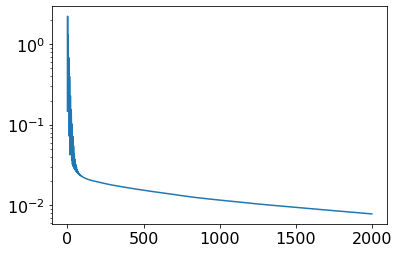

In [374]:
h2 = history2.history['loss']
plt.figure()
plt.plot(range(len(h2)), h2)
plt.yscale('log')

In [375]:
yhat2 = model2.predict(X)

In [376]:
yRes = pugna.data.apply_inverse_scaler(yRes, scalers)
yhat2 = pugna.data.apply_inverse_scaler(yhat2, scalers)

In [377]:
yRes.shape

(400, 1)

In [378]:
yhat2.shape

(400, 1)

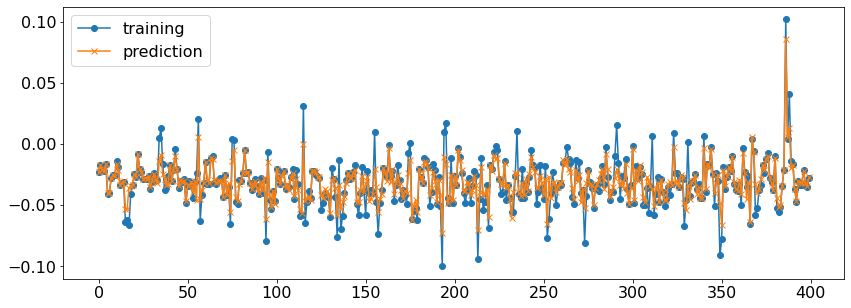

In [379]:
plt.figure(figsize=(14, 5))
plt.plot(range(len(yRes)), yRes, 'C0-o', label='training')
plt.plot(range(len(yRes)), yhat2, 'C1-x' , label='prediction')
plt.legend()

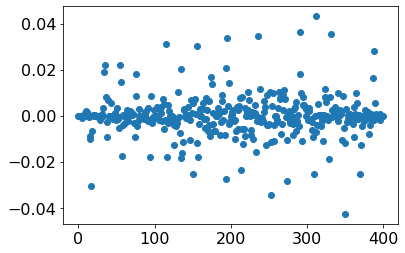

In [380]:
plt.figure()
plt.scatter(range(len(yRes)), yRes-yhat2)

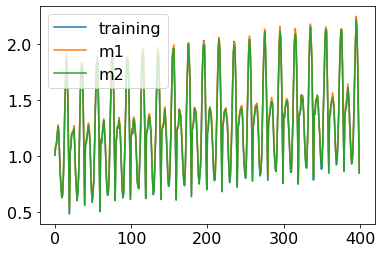

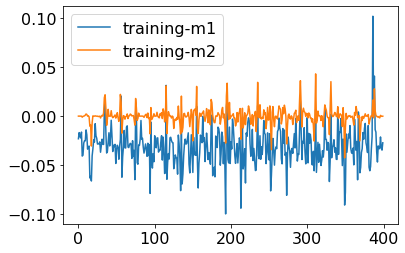

In [381]:
model1_pred = model1.predict(X)
model2_pred = model1.predict(X)+ pugna.data.apply_inverse_scaler(model2.predict(X), scalers)


plt.figure()
plt.plot(range(len(y)), y, label='training')
plt.plot(range(len(y)), model1_pred, label='m1')
plt.plot(range(len(y)), model2_pred, label='m2')
plt.legend()

plt.figure()
plt.plot(range(len(y)), y-model1_pred[:,0], label='training-m1')
plt.plot(range(len(y)), y-model2_pred[:,0], label='training-m2')
plt.legend()

In [382]:
yhat_multistep = model1.predict(X) \
    + pugna.data.apply_inverse_scaler(model2.predict(X), scalers)

yhat_val_multistep = model1.predict(X_val) \
    + pugna.data.apply_inverse_scaler(model2.predict(X_val), scalers)



In [383]:
yhat_multistep.shape

(400, 1)

In [384]:
y.shape

(400,)

In [385]:
yhat.shape

(400, 1)

In [386]:
yhat_multistep.shape

(400, 1)

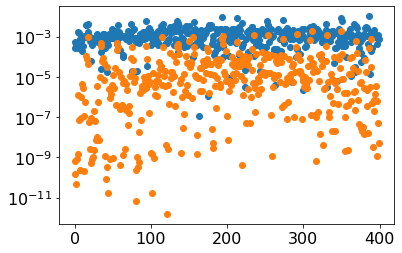

In [387]:
plt.figure()
plt.scatter(n_arr, tf.keras.losses.mean_squared_error(y[:,np.newaxis], yhat))
plt.scatter(n_arr, tf.keras.losses.mean_squared_error(y[:,np.newaxis], yhat_multistep))
plt.yscale('log')

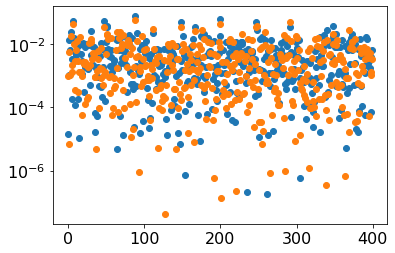

In [388]:
plt.figure()
plt.scatter(n_val_arr, tf.keras.losses.mean_squared_error(y_val[:,np.newaxis], yhat_val))
plt.scatter(n_val_arr, tf.keras.losses.mean_squared_error(y_val[:,np.newaxis], yhat_val_multistep))
plt.yscale('log')